# Meat, Bread, Gold: Illustrating Vector Semantics

Semantic vector spaces is one way of representing word meaning mathematically.
This notebook contains a very basic example of a semantic vector space built using
syntax data for the Hebrew Bible.

There are tools in Python made for building advanced semantic vector spaces that don't
use syntax data, but mere co-occurrence of tokens.

### Read about [bag of words models](https://en.wikipedia.org/wiki/Bag-of-words_model)
### Read about [ngram models](https://en.wikipedia.org/wiki/N-gram)

I'd encourage you to look at [Word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
for more impressive uses of the semantic vector spaces.

The baby-method shown herein is inspired by [Padó and Lapata's syntax model](https://www.researchgate.net/publication/220355312_Dependency-Based_Construction_of_Semantic_Space_Models).

## Research Question: 
### Which two nouns are most similar out of "meat", "bread", and "gold" in Biblical Hebrew?

## Brief

In this notebook, we will compare the semantic similarity of three nouns in the Hebrew Bible:

```
בשׂר    "meat"
לחם    "bread"
זהב     "gold"
```

We will do this using a simple vector semantic model. In particular, we want to see how much distance lies between these three nouns in terms of the the following uses:

* **number of times used as the direct object of נתן "give"**
* **number of times used as the direct object of אכל "eat"**

For the syntax data we will rely on the [BHSA](https://www.github.com/etcbc/bhsa) of the [ETCBC](http://www.etcbc.nl). This data will be accessed using the Python corpus analysis module, [Text-Fabric](https://www.github.com/annotation/text-fabric). 


<hr>

# Python

In [1]:
# load standard modules
import collections
import random

# load Text-Fabric with BHSA data
from tf.app import use
bhsa = use('bhsa', mod='etcbc/heads/tf', silent='deep')
F, T, L, = bhsa.api.F, bhsa.api.T, bhsa.api.L # methods for accessing corpus data

# load data science / plotting modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['Times New Roman'] # setup serif fonts for Hebrew
from bidi.algorithm import get_display # for Hebrew in plots

To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/
To increase the rate,see https://annotation.github.io/text-fabric/Api/Repo/


## Collect instances of "meat", "bread", "gold" in the Hebrew Bible

We will collect all instances of בשׂר, לחם, and זהב that occur as direct objects to either נתן or אכל. We can do this with a Text-Fabric query.

In [3]:
meat_bread_gold = """

clause
    phrase function=Pred|PreS
        word lex=NTN[|>KL[
    phrase function=Predphrase function=Objc
        <nhead- word lex=LXM/|BFR/|ZHB/
"""

query = bhsa.search(meat_bread_gold)

  8.98s 131 results


We get 131 results. Let's sample some at random. Re-run the following cell arbitrarily to show random results in groups of 25.

In [5]:
shuffled_query_results = []

# select 26 examples at random
for i in range(1, 26):
    example = random.choice(query)
    shuffled_query_results.append(example)
    
# show results
for result in shuffled_query_results:
    bhsa.plain(result[0], highlights={result[2], result[4]})

## Build a co-occurrence table of the individual instances

In [6]:
co_occurrences = collections.defaultdict(lambda:collections.Counter()) # e.g. dict[noun][context] += 1

# iterate through results and count noun/co-occurrence features
for result in query:
    noun = F.lex_utf8.v(result[4]) # get UTF8 lex-string:
    co_verb = F.lex_utf8.v(result[2])
    co_occurrences[noun][co_verb] += 1
    
co_occurrences = pd.DataFrame.from_dict(co_occurrences, orient='index').fillna(0) # convert dict to dataframe

We now have a co-occurrence table between our sample nouns and our co-occurrence features. Let's have a look at it.

In [7]:
co_occurrences

,אכל,נתן
לחם,64.0,19
בשׂר,29.0,7
זהב,0.0,12


We normalize the data by converting it into a percentage:

In [8]:
co_occurrences_percent = (co_occurrences.div(co_occurrences.sum(1), axis=0) * 100).round()

co_occurrences_percent

,אכל,נתן
לחם,77.0,23.0
בשׂר,81.0,19.0
זהב,0.0,100.0


We see that, for instance, $77\%$ of לחם's uses are with אכל.

## Plot into basic semantic space

Now we want to model the **distance** between the three nouns. **We can use this distance to answer our research question about which two nouns are most similar.**

Our dataset contains only two variables:

* number of times used as direct object of אכל "to eat"
* number of times used as direct object of נתן "to give"

We can map these variables onto an X and Y axis of a cartesian plane. We do that below:

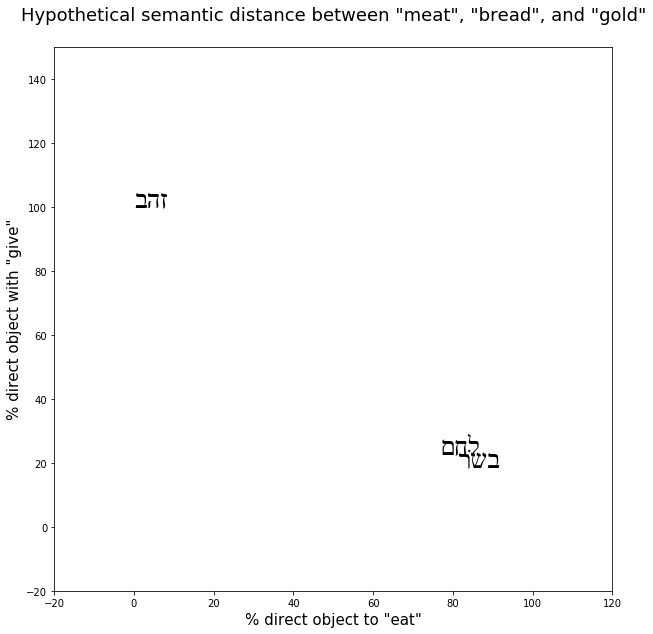

In [9]:
# build matplotlib graph
fig, ax = plt.subplots(figsize=(10, 10))

#ax.scatter(x_axis, y_axis, color='')
ax.set_xlim(-20, 120)
ax.set_ylim(-20, 150)
ax.set_xlabel('% direct object to "eat"', size=15)
ax.set_ylabel('% direct object with "give"', size=15)

# plot words on the graph
for word in co_occurrences_percent.index:
    display_word = get_display(word) # bidirectional text
    x, y = co_occurrences_percent.loc[word]
    ax.text(x, y, s=display_word, size=28, fontfamily='serif')
    
plt.savefig('sem_distance.png', dpi=300, bbox_inches='tight')
ax.set_title('Hypothetical semantic distance between "meat", "bread", and "gold"\n', size=18)

plt.show()

## Measuring the distances

We can see clearly in the graph that בשׂר and לחם ("meat" and "bread") are more similar than זהב ("gold") is to either. If we want to precisely quantify similarity, though, we'll need a way to measure distance between the points. The simplest way to measure the distances between two points in Euclidean space is with the distance formula:

$distance=\sqrt{(x_{2}-x_{1})^2+(y_{2}-y_1)^2}$

Using this formula, we can compare every point in our 3-sample-word dataset pairwise, with $x_{2}$ and $y_{2}$ being the $x$ and $y$ values for a $wordA$ and $x_{1}$ and $y_{1}$ for a $wordB$. We do so below in a loop. The result is a $3x3$ distance matrix that compares the distance of every word in the dataset to every other word.

In [10]:
dist_matrix = [] # data to go here
all_words = co_occurrences_percent.index # words to iterate over

# for every wordA find distance to wordB
for wordA in all_words:
    x2, y2 = co_occurrences_percent.loc[wordA]
    distances = []
    for wordB in all_words:
        x1, y1 = co_occurrences_percent.loc[wordB]
        distance = np.sqrt((x2-x1)**2 + (y2-y1)**2) # cf. formula above
        distances.append(distance)
    dist_matrix.append(distances)
    
# convert to DataFrame with labeled columns/rows
dist_matrix = pd.DataFrame(dist_matrix, columns=all_words, index=all_words)
dist_matrix = dist_matrix.round(2) # round values

Let's have a look at the distance matrix.

In [11]:
dist_matrix

,לחם,בשׂר,זהב
לחם,0.00,5.66,108.89
בשׂר,5.66,0.00,114.55
זהב,108.89,114.55,0.00


Note the $0.00$ distance in the diagonal, which represents a given word's comparison to itself.

We have no successfully quantified the distance between all words. The shortest non-zero distance is between בשׂר and לחם at $5.66$. זהב is the least similar to the two items with distances of $108.89$ and $114.55$. These values give formal confirmation to the visual distance in the scatterplot. We can also take note that זהב is slightly closer to לחם than to בשׂר. Looking at the dataset, we can attribute this to a slightly higher use of לחם with נתן (at $23\%$) and a slightly lower use with אכל (at $77\%$) when compared to בשׂר (respectively, $19\%$ and $81\%$). 

# Looking further

The model shown in this notebook is a very simple example of a [semantic vector space](https://en.wikipedia.org/wiki/Vector_space_model) that consists of three sample words and two features. But most linguistic data contains much more than simply two features. Yet it is still possible to plot such data by applying [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) to the dataset. Dimensionality reduction can compress any number of features into 2 dimensions that can be plotted on a graph. 

The distance formula, on the other hand, works just as well with 3+ dimensions. A method which is better suited for some datasets is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This measure makes it possible to model features as directions in space rather than positions.

There is a lot of literature on semantic vector spaces. Here are some resources which have been particularly helpful:

* Clark, Stephen. "Vector Space Models of Lexical Meaning." In *The Handbook of Contemporary Semantic Theory*, 2015. 493–522. ([online](https://onlinelibrary.wiley.com/doi/abs/10.1002/9781118882139.ch16))
* Levshina, Natalia. "Introduction to Semantic Vector Spaces." In *How to do Linguistics with R*, 2015. 323–331.

# Conclusions

This notebook has shown as simple method of comparing hypothetical semantic distance between two sample words in the Hebrew Bible. We have shown that out of as sample of בשׂר "meat", לחם "bread", זהב "gold", with features of "direct object to 'give'" and "direct object to 'eat'", בשׂר and לחם are most similar to each other. We also looked at the Euclidean distance formula as a means of formally comparing distances between words.